# Chapter 4. Tides, Rotation and Shape #

## Action by Sofía Arboleda-Bolívar ##

This notebook is made with the intention of giving some theoretical and practical tools for the fourth chapter of Murray & Dermott Astrodynamics book.

In [16]:
!pip install --upgrade -q pip
!pip install -q pymcel
!pip install -q celluloid
!pip install -q spiceypy
!pip install -q astroquery 

In [66]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
import astropy 
from astropy import constants as const
from astropy import units as u
import spiceypy as spy
from astroquery.jplhorizons import Horizons
import datetime
from astropy.time import Time

### 4.1 Tidal Bulge 

Derivation of potentials from interaction between a planet and a satellite

Given the potential on a point P on the surface of a planet due to a satellite:

$V = -G \frac{m_s}{\triangle}$

With $\triangle = a\left[ 1 - 2\left(\frac{R_p}{a}\right)cos(\Psi) + \left(\frac{R_p}{a}\right)^2\right]^{1/2}$

And since $R_p/a << 1$, $\triangle$ can be expaned binomially. However, we can consider the polynomial expansion in taylor series using sympy:

In [3]:
#Define x as the Rp/a ratio to expand around it
x, psi = sym.symbols('x, Psi') 

# Define the expression (here we use a negative exponential 
    #due to the position of the polynomial in the potential formula).

expr = (1-2*x*sym.cos(psi)+ x**2 )**(-1/2)

#Perform of Taylor series expansion
taylor_series = sym.series(expr, x, n=3)

display(Markdown('The corresponding expansion is'))
display(taylor_series)


The corresponding expansion is

1 + 1.0*x*cos(Psi) + x**2*(1.5*cos(Psi)**2 - 0.5) + O(x**3)

Now you can see that the potential is given by:
$V=-\mathcal{G} \frac{m_{\mathrm{s}}}{a}\left[1+\left(\frac{R_{\mathrm{p}}}{a}\right) \cos \psi+\left(\frac{R_{\mathrm{p}}}{a}\right)^2 \frac{1}{2}\left(3 \cos ^2 \psi-1\right)+\cdots\right]$

Since the potential can be divided in those first three terms as $V_1, V_2, V_3$, we can look at the contribution of each one of them in the total potential. For that, let's use Earth-Moon system data:


In [51]:
#Constants
R_earth = float(const.R_earth.value) #Earth's radius
G = float(const.G.value)
g = float(const.g0.value)


m_earth = float(const.M_earth.value)
m_moon = 7.342e22 # Moon mass
a_em = 384400e3 # Mean Earth-Moon distance


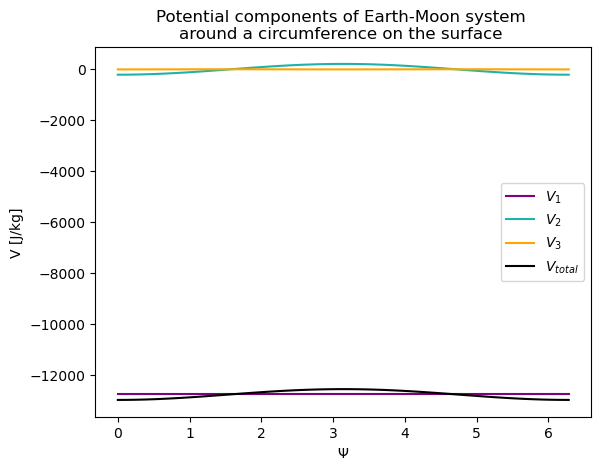

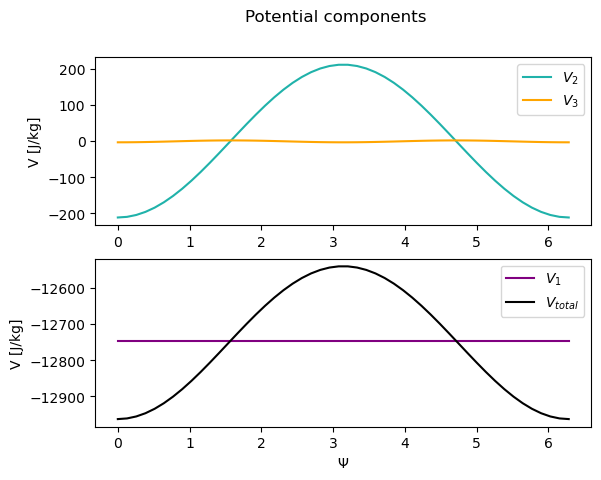

In [52]:
x_s = np.linspace(0, 2*np.pi)

#Legendre polynomial of degree 2 in cos(Psi)
P_2 = lambda psi: (1/2)*(3*np.cos(psi)**2 - 1)

#Potential components
V1 = np.array([-G*(m_moon/a_em) for i in range(len(x_s))]) #Array with constant value
V2 = lambda psi: V1*(R_t/a_em)*np.cos(psi)
V3 = lambda psi: V1*(R_t/a_em)**2*P_2(psi)


#Triangle function 
serie_truncada = taylor_series.removeO() #Remove the higher order factor from the taylor series
V = sym.lambdify((psi, x), serie_truncada,'numpy') #Lambdification of function in terms of psi and x


# Total potential
V_tot = V1[0]*V(x_s, R_t/a_em)

plt.plot(x_s, V1, c='purple', label='$V_{1}$')
plt.plot(x_s, V2(x_s), c='lightseagreen', label='$V_{2}$')
plt.plot(x_s, V3(x_s), c='orange', label='$V_{3}$')
plt.plot(x_s, V_tot, c='black', label='$V_{total}$' )
plt.title('Potential components of Earth-Moon system \naround a circumference on the surface ')
plt.xlabel('$\Psi$')
plt.ylabel('V [J/kg]')
plt.legend()


fig, axs = plt.subplots(2)
fig.suptitle('Potential components')
axs[1].set_xlabel('$\Psi$')
axs[0].set_ylabel('V [J/kg]')
axs[1].set_ylabel('V [J/kg]')
axs[0].plot(x_s, V2(x_s), c='lightseagreen', label='$V_{2}$')
axs[0].plot(x_s, V3(x_s), c='orange', label='$V_{3}$')
axs[1].plot(x_s, V1, c='purple', label='$V_{1}$')
axs[1].plot(x_s, V_tot, c='black', label='$V_{total}$')
axs[0].legend()
axs[1].legend()

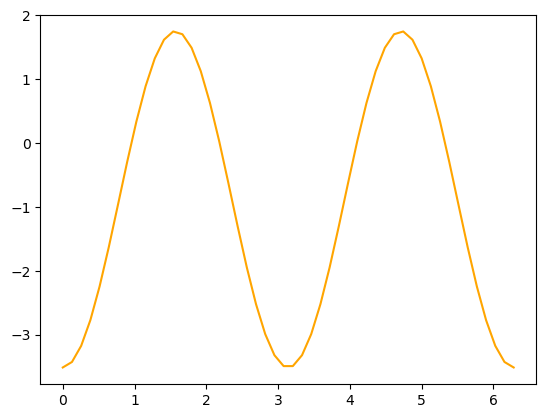

In [5]:
plt.plot(x_s, V3(x_s), c='orange', label='$V_{3}$')

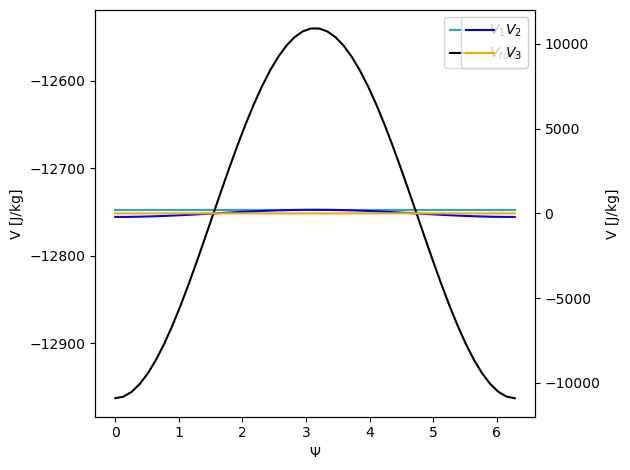

In [6]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('$\Psi$')
ax1.set_ylabel('V [J/kg]')
ax1.plot(x_s, V1, color='lightseagreen', label='$V_{1}$')
ax1.plot(x_s, V_tot, color='black', label='$V_{total}$')
ax1.tick_params(axis='y')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('V [J/kg]')  # we already handled the x-label with ax1
ax2.plot(x_s, V2(x_s), c='blue', label='$V_{2}$')
ax2.plot(x_s, V3(x_s), c='orange', label='$V_{3}$')
ax2.tick_params(axis='y')
ax2.set_ylim([-12000,12000])
ax2.legend()

fig.tight_layout()  
plt.show()

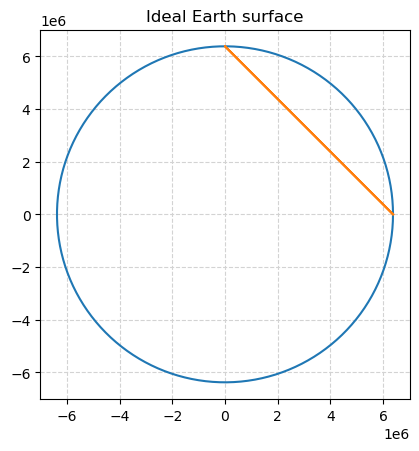

In [7]:
theta = np.linspace(0, 2*np.pi, 150 )

#Circle
a = R_t * np.cos( theta )
b = R_t * np.sin( theta )

#Elipse
a_ = R_t + V3(theta[0])[0]/g  
b_ = R_t    

figure, axes = plt.subplots(1)
 
axes.plot( a, b )
plt.plot( 0.0 + a*np.cos(theta) , 0.0 + b*np.sin(theta) )
plt.grid(color='lightgray',linestyle='--')
axes.set_aspect( 1 )
 
plt.title('Ideal Earth surface')
plt.show()



In [8]:
V3(np.pi/2)[0]/g

0.17893773833352053

We can prove the relation between $\Psi$ angle and the colatitude and longitude of a point on Earth's surface and a satellite, as shown in figure 4.4 of Murray Dermott's:

<img src="Figures&plots/img_1.png" />

 It can be proved that:

$$\cos \psi=\cos \theta_{\mathrm{P}} \cos \theta_{\mathrm{M}}+\sin \theta_{\mathrm{P}} \sin \theta_{\mathrm{M}} \cos \left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right)$$ **Proof using cosine rule**

Hence: $$\begin{aligned} \frac{1}{2}\left(3 \cos ^2 \psi-1\right)= & \frac{1}{2}\left(3 \cos ^2 \theta_{\mathrm{P}}-1\right) \frac{1}{2}\left(3 \cos ^2 \theta_{\mathrm{M}}-1\right) \\ & +\frac{3}{4} \sin ^2 \theta_{\mathrm{P}} \sin ^2 \theta_{\mathrm{M}} \cos 2\left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right) \\  & +\frac{3}{4} \sin 2 \theta_{\mathrm{P}} \sin 2 \theta_{\mathrm{M}} \cos \left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right) .\end{aligned}$$

Let's use a routine to obtain these coordinates from any given point on Earth and and another body. 
For that we're going to need to NAIF kernels imported bellow:

In [44]:
!wget -O earth_200101_990628_predict.bpc https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_200101_990628_predict.bpc

--2023-03-16 08:37:39--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_200101_990628_predict.bpc
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15121408 (14M)
Saving to: 'earth_200101_990628_predict.bpc'

earth_200101_990628 100%[===================>]  14.42M  9.73MB/s    in 1.5s    

2023-03-16 08:37:41 (9.73 MB/s) - 'earth_200101_990628_predict.bpc' saved [15121408/15121408]



In [45]:
!wget -O latest_leapseconds.tls https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/latest_leapseconds.tls

--2023-03-16 08:37:42--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/latest_leapseconds.tls
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5257 (5.1K) [text/plain]
Saving to: 'latest_leapseconds.tls'

latest_leapseconds. 100%[===================>]   5.13K  --.-KB/s    in 0.001s  

2023-03-16 08:37:42 (5.48 MB/s) - 'latest_leapseconds.tls' saved [5257/5257]



Now we can implement the following routine:

In [46]:
def Coordinate_transf(P, S, t):
    """
    This routine is a facility to transform Earth coordinates
    of a given point at a given time to J2000 coordinates.
    
    Input: P = array[lon[º], lat[º], alt[km]], S = array['satellite_name',
    Horizons_id], t = string("yyyy-mm-dd hh:mm:ss")
    
    Output: np.array([phiP, thetaP, phiS, thetaS])
    
    It receives the coordinates of a point P, the indicator of the satellite
    (or celestial body to be used) as a list with a string and a Horizons 
    number indicator and the given date (in date time format) in which the 
    data is going to be taken.
    It returns both coordinates in ecuatorial coordinates in the J2000 system.
    
    *Documentation needed (kernels): earth_200101_990628_predict.bpc & latest_leapseconds.tls
    """
    lon, lat, alt = P[0], P[1], P[2]  
    
    ind = S[1]
    
    t = str(t)

    #Earth's oblateness
    f = 1/298.257223563
    
    #Degrees to radians
    lon = np.radians(lon)
    lat = np.radians(lat)

    rP_earth = spy.georec(lon,lat,alt,6371,f)

    spy.furnsh(["earth_200101_990628_predict.bpc","latest_leapseconds.tls"])  
    
    #UTC to Ephemeris Time
    et = spy.utc2et(t)
    
    #Conversion matrix from International Terrestrial Reference Frame to J200
    R_earth2J2000 = spy.pxform("ITRF93","J2000",et)
    
    #Transformation of coordinates with the matrix 
    rP_J2000 = spy.mxv(R_earth2J2000,rP_earth)

    #From rectangular coordinates to latitudinal coordinates
    d, lon, lat = spy.reclat(rP_J2000) 
    phiP = lon
    thetaP = np.pi/2 - lat #Colatitude

    jd = spy.unitim(et,"ET","JDTDT")

    satellite_data = Horizons(id=ind, location="@3", epochs=jd).ephemerides().to_pandas()
    phiS = np.radians(float(satellite_data.RA))
    thetaS = np.radians(float(90 - satellite_data.DEC))
    
    #print(np.degrees(phiM), np.degrees(thetaM))
    #print(np.degrees(phiP), np.degrees(thetaP))
    
    return np.array([phiP, thetaP, phiS, thetaS])

In [47]:
#Medellin coordinates
P_ = [-75, 6, 1.4]
M_ = ['Moon', 301]

primero = Coordinate_transf(P_, M_, "2023-03-07 19:00:00") #first try of transformation

Now that we can use the coordinates of real objects, it is possible to look at the raising part of the potential given by: 

$$V_3(\psi)=-\zeta g \mathcal{P}_2(\cos \psi)$$

Where $$\zeta=\frac{m_{\mathrm{s}}}{m_{\mathrm{p}}}\left(\frac{R_{\mathrm{p}}}{a}\right)^3 R_{\mathrm{p}}$$

And $$g=\frac{\mathcal{G} m_{\mathrm{p}}}{R_{\mathrm{p}}^2}$$



In [53]:

#Legendre polynomial of degree 2 in cos(Psi)
P_2 = lambda cospsi: (1/2)*(3*cospsi**2 - 1)

def cosPsi(coord):
 
    phiP = coord[0]
    thetaP = coord[1]
    phiS = coord[2]
    thetaS = coord[3]
    cosine = np.cos(thetaP)*np.cos(thetaS) + np.sin(thetaP)*np.sin(thetaS)*np.cos(phiP-phiS)
    
    return cosine 

sigma_g = lambda ms, mp, Rp, a: Rp*(ms/mp)*(Rp/a)**3*(G*mp/Rp**2)

Tide = lambda cos_Psi, ms, mp, Rp, a: -sigma_g(ms, mp, Rp, a)*P_2(cos_Psi)

"""
#Constants
R_earth = float(const.R_earth.value) #Earth's radius
G = float(const.G.value)
g = float(const.g0.value)


m_earth = float(const.M_earth.value)
m_moon = 7.342e22 # Moon mass
a_em = 384400e3 # Mean Earth-Moon distance
"""
Tide(cosPsi(primero), m_moon, m_earth, R_earth, a_em )

-2.4545757904093968

In [104]:
#For a hole day in the same point (Medellin) using Time from astropy

start = ['2023-03-07 00:00:00']
tstart = Time(start, format='iso', scale='utc')
stop = ['2023-03-08 00:00:00']
tstp = Time(stop, format='iso', scale='utc')

time = np.linspace(tstart, tstp, 100, endpoint=False)
time[0][0].value

'2023-03-07 00:00:00.000'

In [96]:
#t_ = Time.strftime(time, '%Y-%b-%d %H:%M:%S' )
#t_[0]#.astype('float')

array(['2023-Mar-07 00:00:00'], dtype='<U20')

In [107]:
Coords = []
for i in range(len(time)):
    Coords.append(Coordinate_transf(P_, M_, time[i][0].value)) 

*IDEAS:* 
$\rightarrow$ Look at the tide raising part of the potential and compare with real data meassured ($V_3 = -\zeta g P_2(cos(\Psi))$).

$\rightarrow$ Show the two high tides and two low tides (maximum and minimum of the function) on earth during a day. (Maybe with a dynamical plot on a sphere showing the four tides).

$\rightarrow$ Use data of colatitudes and longitudes of the Moon (θM , φM ) and a point
P (θP,φP) on the surface of the Earth (look at the behavoir of the variables).

### 4.2 Potential Theory 

*IDEAS:* 
$\rightarrow$ ¿What does the Legendre polynomials and Spherical surface harmonics are? Show a mathematical tool and/or graphics to understand the math behind the theory presented in this section. (Steps to derive the external and internal potential already knowing the math behind).

$\rightarrow$ ¿What is an equipotential surface and how does the text uses it? (Graphics)

### 4.3 Tidal deformation

*IDEAS:* 
$\rightarrow$ Derive the proof of Chree (1896a): the yielding of the core under the force resulting from the core deforming potential is the same as that which would be produced by an outward normal force per unit area of amount ρZ A2P2(cosψ) acting at the mean core boundary, r = A.

$\rightarrow$ show that the radial displacement of the solid core produced by this deforming pressure is $\Delta R(\Psi)...$ (Love (1944)).

$\rightarrow$ Study F (measure of the effect of the ocean on the amplitude of the core tide), and H (measure of the effect of the internal structure on the external shape of the planet) in different planets with their satellites. Look at the difference when the case is for a satellite with spin rate equal to or synchronous with its orbital mean motion (hydrostatic value of H).

$\rightarrow$ Compare the amplitude of ocean tide in different cases (for the uniform ocean model) σ = ρ, with the equilibrium tide and the amplitude of the solid body tide for a planet with and without ocean.

$\rightarrow$ Calculate the height of the surface above the ocean floor for a real ocean basin and look at the variability with the general assumption for the whole earth (importance of currents on determining the shape of Earth's oceans).


### 4.5 Rotational Deformation
*IDEAS:* 
$\rightarrow$ Construct the oblate spheroid (shape of the distorted planet) using Legendre polynomial of degree 2 where the angle ψ is measured from the axis of symmetry.

$\rightarrow$ Compare the flatness of some planets calculated by the difference between radius and by the realtion with the rotational velocity. (without considering the rotational distortion).

$\rightarrow$ Look at the upper limit on the rotational velocity of the solar system planets and their corresponding rotation period (animation with the spheres and different velocities?).



### 4.6 The Darwin-Radau Relation

$\rightarrow$ Moment of inertia factor (C-) graphic for different planetary systems (if possible). Look at the Darwin–Radau model, and other general core–mantle models.

### 4.7 Shapes and Internal Structures of Satellites

$\rightarrow$ Interactive equipotential surfaces arising from rotational deformation and from tidal deformation.

$\rightarrow$ Which studies have been done in the determination of internal structures using the shape technique described in the text (example of Mimas and Jovian system)? Is it really convenient or other thechniques are being applied nowadays to determine better the shape of planets and satellites?

### 4.8 The Roche Zone 

### 4.9 Tidal Torques

### 4.10 Satellite Tides

In [1]:
!pip install -q spiceypy


In [3]:
import spiceypy as spy

In [24]:
import numpy as np
deg = np.pi/180
rad = 1/deg

f = 1/298.257223563

In [25]:
lon = -75*deg
lat = 6*deg
alt = 1.4 #km

rP_earth = spy.georec(lon,lat,alt,6371,f)
rP_earth

array([ 1640.32343129, -6121.77038641,   661.66324483])

In [26]:
spy.furnsh(["earth_200101_990628_predict.bpc","latest_leapseconds.tls"])

In [27]:
et = spy.utc2et("2023-03-07 19:00:00")
R_earth2J2000 = spy.pxform("ITRF93","J2000",et)

In [28]:
rP_J2000 = spy.mxv(R_earth2J2000,rP_earth)
rP_J2000

array([6124.91521683, 1634.04997249,  647.93992528])

In [29]:
d,lon,lat=spy.reclat(rP_J2000) #from rectangular coordinates to latitudinal coordinates.

phiP = lon
tetaP = np.pi/2 - lat

d,phiP*rad,tetaP*rad

(6372.1685376883415, 14.937873202139134, 84.16391829273529)

In [26]:
!pip install -q astroquery

In [2]:
from astroquery.jplhorizons import Horizons

In [30]:
jd = spy.unitim(et,"ET","JDTDT")
jd

2460011.2924674074

In [31]:
datos_luna = Horizons(id="301",location="@3",epochs=jd).ephemerides().to_pandas()

In [32]:
phiM = (datos_luna.RA)*deg
tetaM = (90 - datos_luna.DEC)*deg
phiM*rad, tetaM*rad

(0    171.84935
 Name: RA, dtype: float64,
 0    82.54474
 Name: DEC, dtype: float64)